# Modeling work on the CO v=0-1 absorption band

In [1]:
basepath = '/orange/adamginsburg/jwst/brick'

In [2]:
import numpy as np
import pyspeckitmodels

Could not find atran.txt.  atran atmospheric transition model will not be available


In [3]:
from astropy import units as u

In [4]:
from tqdm.notebook import tqdm

In [5]:
from astroquery.svo_fps import SvoFps

In [6]:
%matplotlib inline
import matplotlib.pyplot as pl
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['font.size'] = 16

In [7]:
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
filt470 = 'F470N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
wavelength_table_470 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt470}')

In [8]:
wavelength_table_466[:5]

Wavelength,Transmission
AA,
float64,float64
45658.1,0.000107229
45671.6,0.00014
45685.1,0.000181014
45698.6,0.000231183
45712.2,0.000291353


In [9]:
filterlist = SvoFps.get_filter_list('JWST', 'NIRCam')
filterlist.add_index('filterID')

In [10]:
filterlist.loc['JWST/NIRCam.F466N']

FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,Description,Comments,WavelengthRef,WavelengthMean,WavelengthEff,WavelengthMin,WavelengthMax,WidthEff,WavelengthCen,WavelengthPivot,WavelengthPeak,WavelengthPhot,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
,,,,,,,,,,,,,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,erg s / (A cm2),,,Jy,,,,,
object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,object,float64,object
ivo://svo/fps,JWST/NIRCam.F466N,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F466N filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",46544.303736584,46545.305761355,46540.477222667,46021.350197247,47042.621884854,535.40523943323,46548.339825337,46544.303736584,46563.4,46541.156644092,520.35830830914,0.42613770545148,JWST/NIRCam.F466N/Vega,Vega,157.77306515275,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F466N


In [11]:
import imp
from pyspeckitmodels.sio import exomol_sio_vibration 
imp.reload(exomol_sio_vibration); from pyspeckitmodels.sio.exomol_sio_vibration import exomol_xsec, transitions, levels, tau_of_N, test, test2

In [12]:
import imp
from pyspeckitmodels.co import exomol_co_vibration 
imp.reload(exomol_co_vibration); from pyspeckitmodels.co.exomol_co_vibration import exomol_xsec, transitions, levels, tau_of_N, test, test2

In [13]:
# this takes a while to load the first time especially
from pyspeckitmodels.sio.exomol_sio_vibration import exomol_xsec as SiO_exomol_xsec
from pyspeckitmodels.co.exomol_co_vibration import exomol_xsec as CO_exomol_xsec, tau_of_N as CO_tau_of_N
from astropy import constants

Text(0.5, 1.0, 'Failed sanity check: the opacities from exomol seem to be ~3 orders of magnitude lower')

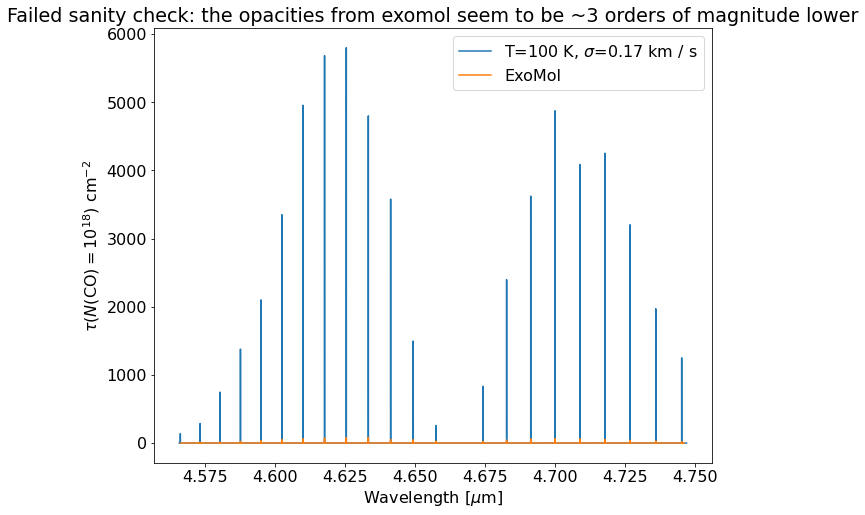

In [14]:
fig = pl.figure()

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(5e4))

T = 100
width = ((constants.k_B * T*u.K / (28*u.Da))**0.5).to(u.km/u.s)
column = 1e18
L, = pl.plot(xarr,
             pyspeckitmodels.co_vibration.tau_of_N(xarr.to(u.cm).value, column, T, width=width.value),
             label=f"T={T} K, $\sigma$={width:0.2f}")

# sanity check based on exomol
exomol_sigmas = CO_exomol_xsec(
                            np.round(xarr.max().to(u.cm**-1, u.spectral()).value),
                            np.round(xarr.min().to(u.cm**-1, u.spectral()).value),
                            dnu=0.01,
                            temperature=T)
wl_exo = (np.arange(np.round(xarr.max().to(u.cm**-1, u.spectral()).value),
                    np.round(xarr.min().to(u.cm**-1, u.spectral()).value)+0.005,
                    0.01)*u.cm**-1).to(u.um, u.spectral())
pl.plot(wl_exo, exomol_sigmas * column*u.cm**-2, label='ExoMol')
    
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$\\tau(N(\\mathrm{CO})=10^{18})~\mathrm{cm^{-2}}$")
pl.title("Failed sanity check: the opacities from exomol seem to be ~3 orders of magnitude lower")

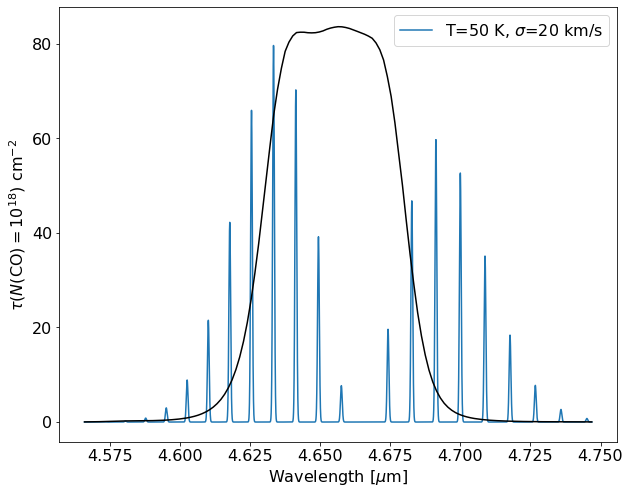

In [15]:
fig = pl.figure()
assert np.all(fig.get_size_inches() == (10,8))

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    L, = pl.plot(xarr,
                    pyspeckitmodels.co_vibration.tau_of_N(xarr.to(u.cm).value, 1e18, T, width=20), label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$\\tau(N(\\mathrm{CO})=10^{18})~\mathrm{cm^{-2}}$")
fig.savefig(f'{basepath}/paper_figures/CO_F466N_opticaldepth_example_1e18_tau.pdf', bbox_inches='tight')

  0%|          | 0/755 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.96


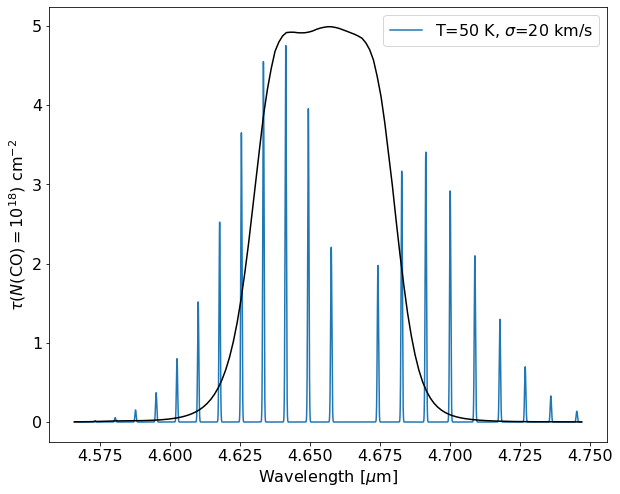

In [16]:
fig = pl.figure()
assert np.all(fig.get_size_inches() == (10,8))

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    L, = pl.plot(xarr,
                 CO_tau_of_N(xarr, 1e18*u.cm**-2, T*u.K, width=20*u.km/u.s),
                 label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$\\tau(N(\\mathrm{CO})=10^{18})~\mathrm{cm^{-2}}$")
fig.savefig(f'{basepath}/paper_figures/CO_F466N_opticaldepth_example_1e18_tau_exomol.pdf', bbox_inches='tight')

In [17]:
x = 1*u.dimensionless_unscaled
x.unit.is_equivalent(u.dimensionless_unscaled)

True

  0%|          | 0/755 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.96


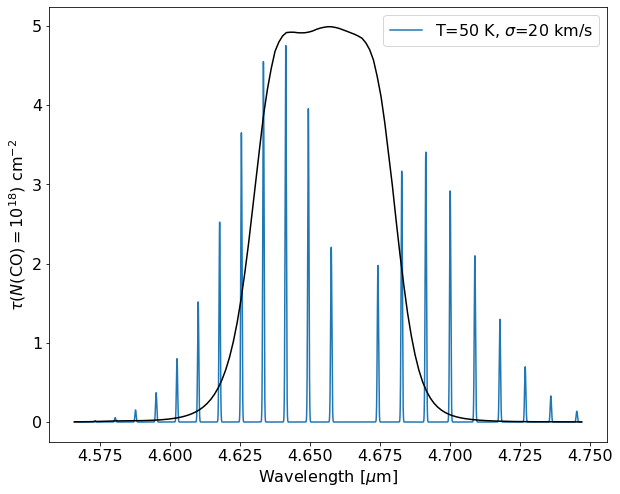

In [18]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    L, = pl.plot(xarr,
                 CO_tau_of_N(xarr.to(u.cm), 1e18*u.cm**-2, T*u.K, width=20*u.km/u.s), label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$\\tau(N(\\mathrm{CO})=10^{18})~\mathrm{cm^{-2}}$");

  0%|          | 0/755 [00:00<?, ?it/s]

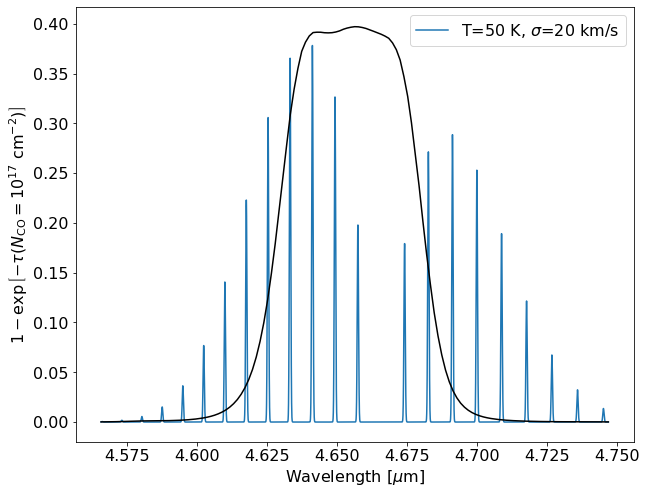

In [19]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    tau = CO_tau_of_N(xarr.to(u.cm), 1e17*u.cm**-2, T*u.K, width=20*u.km/u.s)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{17}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_1e17_exptau.pdf', bbox_inches='tight');

  0%|          | 0/755 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.96


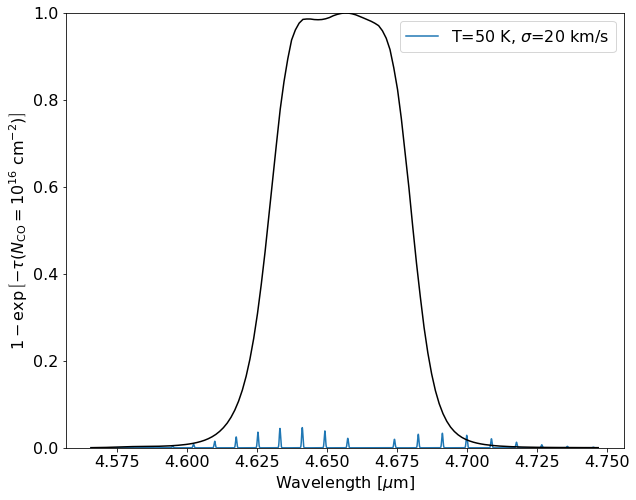

In [20]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e16, T, width=20)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))
    
pl.ylim(0,1)
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{16}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_1e16_exptau.pdf', bbox_inches='tight');

  0%|          | 0/755 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.96


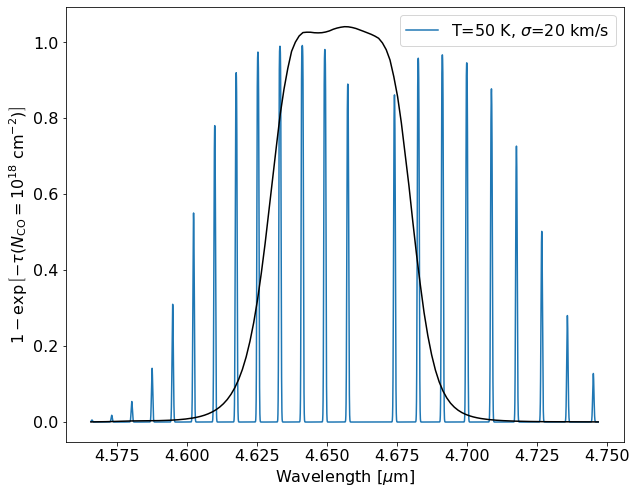

In [21]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e18, T, width=20)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{18}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_1e18_exptau.pdf', bbox_inches='tight');

  0%|          | 0/755 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.96


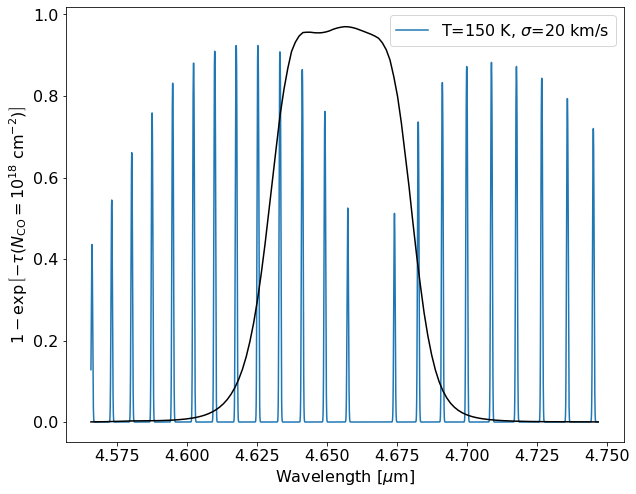

In [66]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [150, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e18, T, width=20)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{18}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_1e18_t150_exptau.pdf', bbox_inches='tight');

  0%|          | 0/755 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.96


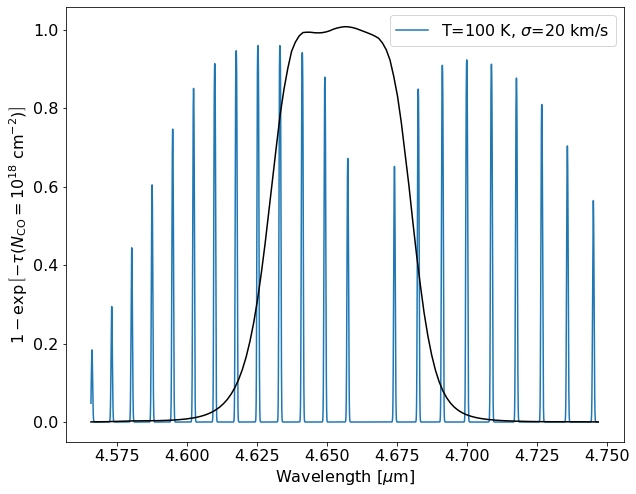

In [65]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [100, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e18, T, width=20)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))

xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{18}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_1e18_t100_exptau.pdf', bbox_inches='tight');

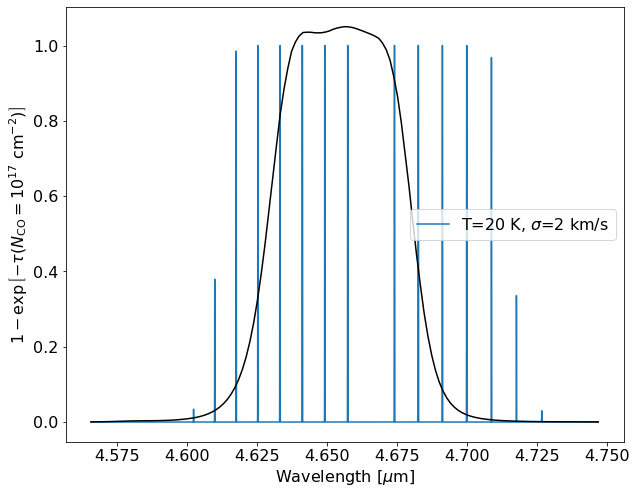

In [22]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [20, ]:
    tau = pyspeckitmodels.co_vibration.tau_of_N(xarr.to(u.cm).value, 1e17, T, width=2)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=2 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_{\\mathrm{CO}}=10^{17}\\mathrm{~cm}^{-2})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_DiskClouds.pdf', bbox_inches='tight')

  0%|          | 0/755 [00:00<?, ?it/s]

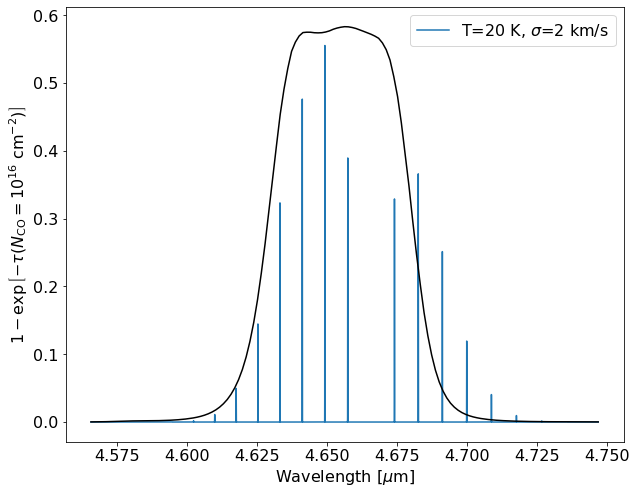

In [23]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [20, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e16, T, width=2)
    L, = pl.plot(xarr,
                    (1-np.exp(-tau)), label="T={0} K, $\sigma$=2 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_{\\mathrm{CO}}=10^{16}\\mathrm{~cm}^{-2})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorptionspectrum_example_DiskClouds_thin.pdf', bbox_inches='tight')

In [68]:
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))
trans = np.interp(xarr, wavelength_table_466['Wavelength'], wavelength_table_466['Transmission'])
transmission_sum = (trans).sum()
def fractional_absorption(temperature, column, linewidth):
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value,
                                                column.to(u.cm**-2).value,
                                                temperature.to(u.K).value,
                                                width=linewidth.to(u.km/u.s).value,
                                                          progressbar=lambda x: x,
                                                         )
    absorbed_fraction = ((1-np.exp(-tau)) * trans).sum() / transmission_sum
    return absorbed_fraction

$\sigma=1.0 km / s$; $T_{max} = 20.8 K
$\sigma=12.0 km / s$; $T_{max} = 18.8 K
$\sigma=23.0 km / s$; $T_{max} = 17.2 K
$\sigma=34.0 km / s$; $T_{max} = 16.2 K
$\sigma=45.0 km / s$; $T_{max} = 14.7 K
$\sigma=56.0 km / s$; $T_{max} = 14.2 K
$\sigma=67.0 km / s$; $T_{max} = 13.2 K
$\sigma=78.0 km / s$; $T_{max} = 12.7 K
$\sigma=89.0 km / s$; $T_{max} = 12.1 K
$\sigma=100.0 km / s$; $T_{max} = 11.6 K


Text(0, 0.5, 'Fractional Absorption')

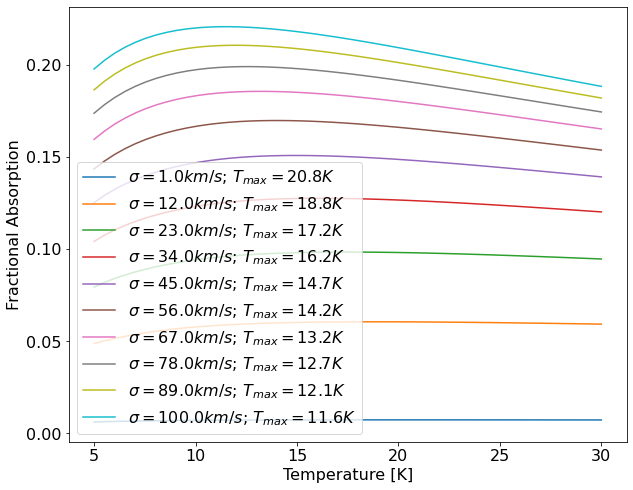

In [73]:
temperatures = np.linspace(5, 30, 50)*u.K
column = 1e18*u.cm**-2
sig = 20*u.km/u.s
for sig in np.linspace(1, 100, 10)*u.km/u.s:
    grid1d = [fractional_absorption(T, column, sig) for T in temperatures]
    tmax = temperatures[np.argmax(grid1d)]
    pl.plot(temperatures, grid1d, label=f'$\\sigma={sig:0.1f}$; $T_{{max}} = {tmax:0.1f}$')
    print(f'$\\sigma={sig:0.1f}$; $T_{{max}} = {tmax:0.1f}')
pl.legend(loc='best')
pl.xlabel("Temperature [K]")
pl.ylabel("Fractional Absorption")

In [74]:
temperatures = np.linspace(5, 150, 50)*u.K
linewidths = np.linspace(1, 100, 24)*u.km/u.s
column = 1e18*u.cm**-2
grid = [[fractional_absorption(T, column, sig) for T in temperatures]
        for sig in tqdm(linewidths)]

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.99
Line profile is not normalized.  Sum is 0.97
Line profile is not normalized.  Sum is 0.94
Line profile is not normalized.  Sum is 0.9
Line profile is not normalized.  Sum is 0.87
Line profile is not normalized.  Sum is 0.84
Line profile is not normalized.  Sum is 0.81
Line profile is not normalized.  Sum is 0.76
Line profile is not normalized.  Sum is 0.74
Line profile is not normalized.  Sum is 0.91
Line profile is not normalized.  Sum is 0.71
Line profile is not normalized.  Sum is 0.88
Line profile is not normalized.  Sum is 0.69
Line profile is not normalized.  Sum is 0.86
Line profile is not normalized.  Sum is 0.68
Line profile is not normalized.  Sum is 0.66
Line profile is not normalized.  Sum is 0.98
Line profile is not normalized.  Sum is 0.82
Line profile is not normalized.  Sum is 0.8
Line profile is not normalized.  Sum is 0.79


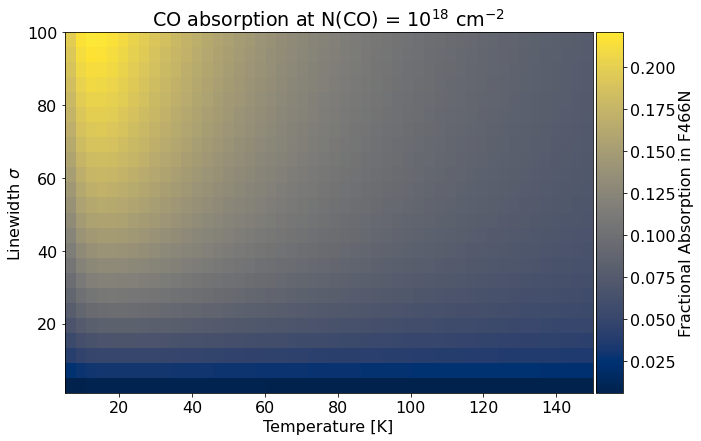

In [75]:
ax = pl.gca()
im = ax.imshow(grid, extent=[temperatures.min().value, temperatures.max().value,
                             linewidths.min().value, linewidths.max().value],
          origin='lower', cmap='cividis')
pl.xlabel("Temperature [K]")
pl.ylabel("Linewidth $\sigma$")
pl.title("CO absorption at N(CO) = 10$^{18}$ cm$^{-2}$")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = pl.colorbar(cax=cax, mappable=im)
   
cb.set_label("Fractional Absorption in F466N")

In [76]:
levels=[0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 0.9]
colors=['w', 'y', 'g', 'c', 'r', 'b', 'purple', 'orange', 'maroon', 'springgreen']

In [77]:
# mag1 - mag2 = 2.5 log flux1/flux2
2.5 * np.log10(1-np.array(levels))

array([-0.01091201, -0.05569099, -0.11439373, -0.17645269, -0.24227503,
       -0.3872549 , -0.55462187, -0.75257499, -1.50514998, -2.5       ])

In [83]:
# mag1 - mag2 = 2.5 log flux1/flux2
', '.join([f'{np.abs(x):0.3f}' for x in 2.5 * np.log10(1-np.array(levels))])

'0.011, 0.056, 0.114, 0.176, 0.242, 0.387, 0.555, 0.753, 1.505, 2.500'

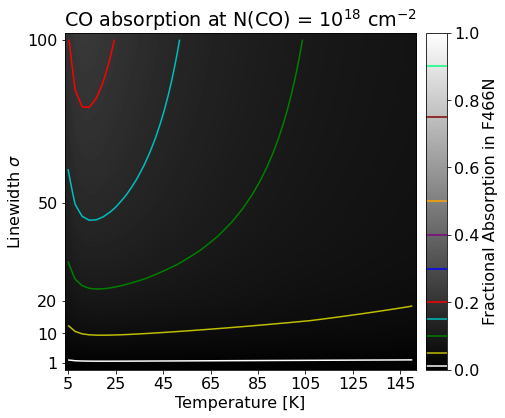

In [122]:
ax = pl.gca()
im = ax.imshow(grid, 
               #extent=[np.log10(column.min().value), np.log10(column.max().value),
               #        linewidths.min().value, linewidths.max().value],
               origin='lower',
               interpolation='bilinear',
               vmin=0,
               vmax=1,
               cmap='gray')
con = ax.contour(grid, levels=levels, colors=colors)
pl.xlabel("Temperature [K]")
pl.ylabel("Linewidth $\sigma$")
pl.title("CO absorption at N(CO) = 10$^{18}$ cm$^{-2}$")


sigma_labels = [1,10,20,50,100]
ax.yaxis.set_ticks(np.interp(sigma_labels, linewidths.value, np.arange(len(linewidths)), right=np.nan),
                   labels=sigma_labels)
tem_labels = np.arange(temperatures.min().value, temperatures.max().value, 20, dtype='int')
ax.xaxis.set_ticks(np.interp(tem_labels, (temperatures.value), np.arange(len(temperatures)), right=np.nan),
                   labels=tem_labels)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-2.3)
cb = pl.colorbar(cax=cax, mappable=im)
cb.set_label("Fractional Absorption in F466N")
cb.ax.hlines(con.levels, *cb.ax.get_xlim(), colors=con.colors)
ax.set_aspect(2)


pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorption_1e18co_coldens.pdf', bbox_inches='tight')

In [79]:
temperature = 60*u.K
linewidths = np.linspace(1, 100, 24)*u.km/u.s
column = np.logspace(15,19,24)*u.cm**-2
grid_sigcol = [[fractional_absorption(temperature, col, sig) for col in column]
                for sig in tqdm(linewidths)]

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.99
Line profile is not normalized.  Sum is 0.97
Line profile is not normalized.  Sum is 0.94
Line profile is not normalized.  Sum is 0.9
Line profile is not normalized.  Sum is 0.87
Line profile is not normalized.  Sum is 0.84
Line profile is not normalized.  Sum is 0.81
Line profile is not normalized.  Sum is 0.78
Line profile is not normalized.  Sum is 0.76
Line profile is not normalized.  Sum is 0.74
Line profile is not normalized.  Sum is 0.73
Line profile is not normalized.  Sum is 0.71
Line profile is not normalized.  Sum is 0.7
Line profile is not normalized.  Sum is 0.69
Line profile is not normalized.  Sum is 0.68
Line profile is not normalized.  Sum is 0.67
Line profile is not normalized.  Sum is 0.66
Line profile is not normalized.  Sum is 0.65
Line profile is not normalized.  Sum is 0.64


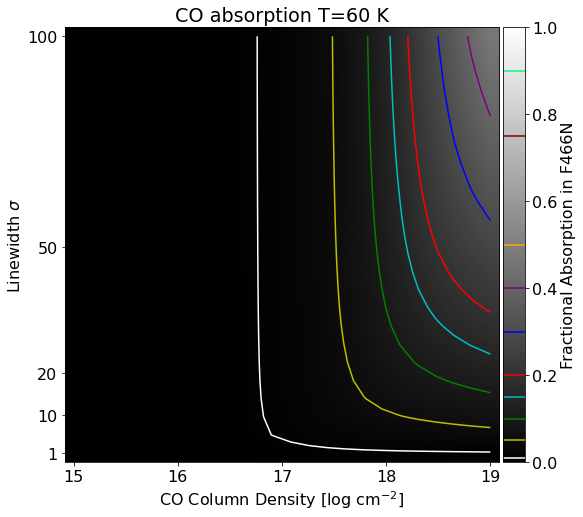

In [31]:
ax = pl.gca()
im = ax.imshow(grid_sigcol, 
               #extent=[np.log10(column.min().value), np.log10(column.max().value),
               #        linewidths.min().value, linewidths.max().value],
               origin='lower',
               interpolation='bilinear',
               vmin=0,
               vmax=1,
               cmap='gray')
con = ax.contour(grid_sigcol, levels=levels, colors=colors)
pl.xlabel("CO Column Density [log cm$^{-2}$]")
pl.ylabel("Linewidth $\sigma$")
pl.title("CO absorption T=60 K")


# a hideous way to format the axis
# @pl.FuncFormatter
# def log_scaler(x, pos):
#     'The two args are the value and tick position'
#     try:
#         col = np.interp(x, np.arange(len(column)), column.value)
#         return f'{np.log10(col):0.1f}'
#     except Exception:
#         return None
# ax.xaxis.set_major_formatter(log_scaler)
# @pl.FuncFormatter
# def sig_scaler(x, pos):
#     'The two args are the value and tick position'
#     sig = np.interp(x, np.arange(len(linewidths)), linewidths.value)
#     return f'{sig:0.1f}'
# ax.yaxis.set_major_formatter(sig_scaler)
sigma_labels = [1,10,20,50,100]
ax.yaxis.set_ticks(np.interp(sigma_labels, linewidths.value, np.arange(len(linewidths)), right=np.nan),
                   labels=sigma_labels)
col_labels = [15,16,17,18,19,]
ax.xaxis.set_ticks(np.interp(col_labels, np.log10(column.value), np.arange(len(column)), right=np.nan),
                   labels=col_labels)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = pl.colorbar(cax=cax, mappable=im)
cb.set_label("Fractional Absorption in F466N")
cb.ax.hlines(con.levels, *cb.ax.get_xlim(), colors=con.colors)


pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorption_60K.pdf', bbox_inches='tight')

In [32]:
temperature = 20*u.K
linewidths = np.linspace(1, 100, 24)*u.km/u.s
column = np.logspace(15,19,24)*u.cm**-2
grid_sigcol_20K = [[fractional_absorption(temperature, col, sig) for col in column]
                for sig in tqdm(linewidths)]

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.99
Line profile is not normalized.  Sum is 0.97
Line profile is not normalized.  Sum is 0.94
Line profile is not normalized.  Sum is 0.9
Line profile is not normalized.  Sum is 0.87
Line profile is not normalized.  Sum is 0.84
Line profile is not normalized.  Sum is 0.81
Line profile is not normalized.  Sum is 0.78
Line profile is not normalized.  Sum is 0.76
Line profile is not normalized.  Sum is 0.74
Line profile is not normalized.  Sum is 0.73
Line profile is not normalized.  Sum is 0.71
Line profile is not normalized.  Sum is 0.7
Line profile is not normalized.  Sum is 0.69
Line profile is not normalized.  Sum is 0.68
Line profile is not normalized.  Sum is 0.67
Line profile is not normalized.  Sum is 0.66
Line profile is not normalized.  Sum is 0.65
Line profile is not normalized.  Sum is 0.64


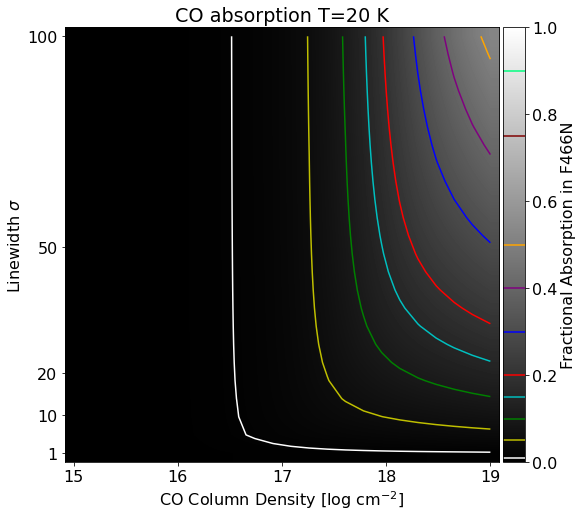

In [33]:
ax = pl.gca()
im = ax.imshow(grid_sigcol_20K, 
               #extent=[np.log10(column.min().value), np.log10(column.max().value),
               #        linewidths.min().value, linewidths.max().value],
               origin='lower',
               interpolation='bilinear',
               vmin=0,
               vmax=1,
               cmap='gray')
con = ax.contour(grid_sigcol_20K, levels=levels, colors=colors)
pl.xlabel("CO Column Density [log cm$^{-2}$]")
pl.ylabel("Linewidth $\sigma$")
pl.title("CO absorption T=20 K")


# a hideous way to format the axis
# @pl.FuncFormatter
# def log_scaler(x, pos):
#     'The two args are the value and tick position'
#     try:
#         col = np.interp(x, np.arange(len(column)), column.value)
#         return f'{np.log10(col):0.1f}'
#     except Exception:
#         return None
# ax.xaxis.set_major_formatter(log_scaler)
# @pl.FuncFormatter
# def sig_scaler(x, pos):
#     'The two args are the value and tick position'
#     sig = np.interp(x, np.arange(len(linewidths)), linewidths.value)
#     return f'{sig:0.1f}'
# ax.yaxis.set_major_formatter(sig_scaler)
sigma_labels = [1,10,20,50,100]
ax.yaxis.set_ticks(np.interp(sigma_labels, linewidths.value, np.arange(len(linewidths)), right=np.nan),
                   labels=sigma_labels)
col_labels = [15,16,17,18,19,]
ax.xaxis.set_ticks(np.interp(col_labels, np.log10(column.value), np.arange(len(column)), right=np.nan),
                   labels=col_labels)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = pl.colorbar(cax=cax, mappable=im)
cb.set_label("Fractional Absorption in F466N")
cb.ax.hlines(con.levels, *cb.ax.get_xlim(), colors=con.colors)


pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorption_20K_matched_60K.pdf', bbox_inches='tight')

In [34]:
temperature = 20*u.K
linewidths = np.linspace(0.1, 10, 24)*u.km/u.s
column = np.logspace(15,19,24)*u.cm**-2
grid_sigcol_20K = [[fractional_absorption(temperature, col, sig) for col in column]
                for sig in tqdm(linewidths)]

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 7.5e-11
Line profile is not normalized.  Sum is 0.067
Line profile is not normalized.  Sum is 0.66
Line profile is not normalized.  Sum is 0.00084
Line profile is not normalized.  Sum is 3.9e-10
Line profile is not normalized.  Sum is 1.6e-09
Line profile is not normalized.  Sum is 0.0002
Line profile is not normalized.  Sum is 0.0032
Line profile is not normalized.  Sum is 2.7e-14
Line profile is not normalized.  Sum is 3.3e-14
Line profile is not normalized.  Sum is 8.4e-08
Line profile is not normalized.  Sum is 1.8e-13
Line profile is not normalized.  Sum is 0.046
Line profile is not normalized.  Sum is 3.4e-07
Line profile is not normalized.  Sum is 0.00028
Line profile is not normalized.  Sum is 0.00021
Line profile is not normalized.  Sum is 3.4e-06
Line profile is not normalized.  Sum is 0.84
Line profile is not normalized.  Sum is 0.83
Line profile is not normalized.  Sum is 0.77
Line profile is not normalized.  Sum is 0.76
Line profile 

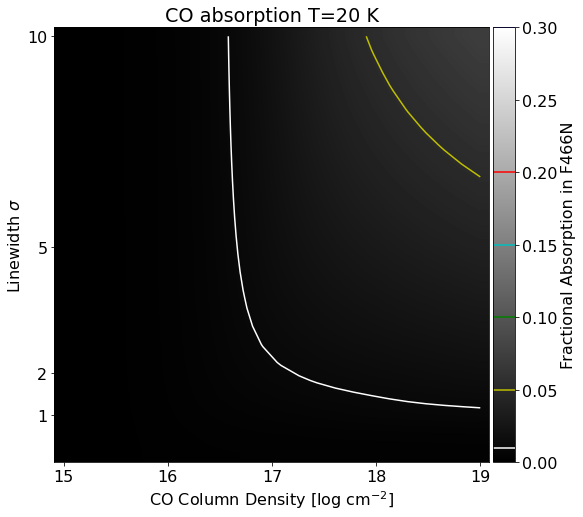

In [35]:
ax = pl.gca()
im = ax.imshow(grid_sigcol_20K, 
               #extent=[np.log10(column.min().value), np.log10(column.max().value),
               #        linewidths.min().value, linewidths.max().value],
               origin='lower',
               interpolation='bilinear',
               vmin=0,
               vmax=0.3,
               cmap='gray')
con = ax.contour(grid_sigcol_20K, levels=levels, colors=colors)
pl.xlabel("CO Column Density [log cm$^{-2}$]")
pl.ylabel("Linewidth $\sigma$")
pl.title("CO absorption T=20 K")


# a hideous way to format the axis
# @pl.FuncFormatter
# def log_scaler(x, pos):
#     'The two args are the value and tick position'
#     try:
#         col = np.interp(x, np.arange(len(column)), column.value)
#         return f'{np.log10(col):0.1f}'
#     except Exception:
#         return None
# ax.xaxis.set_major_formatter(log_scaler)
# @pl.FuncFormatter
# def sig_scaler(x, pos):
#     'The two args are the value and tick position'
#     sig = np.interp(x, np.arange(len(linewidths)), linewidths.value)
#     return f'{sig:0.1f}'
# ax.yaxis.set_major_formatter(sig_scaler)
sigma_labels = [1,2,5,10,20,50,100]
ax.yaxis.set_ticks(np.interp(sigma_labels, linewidths.value, np.arange(len(linewidths)), right=np.nan),
                   labels=sigma_labels)
col_labels = [15,16,17,18,19,]
ax.xaxis.set_ticks(np.interp(col_labels, np.log10(column.value), np.arange(len(column)), right=np.nan),
                   labels=col_labels)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = pl.colorbar(cax=cax, mappable=im)
cb.set_label("Fractional Absorption in F466N")
cb.ax.hlines(con.levels, *cb.ax.get_xlim(), colors=con.colors)


pl.savefig(f'{basepath}/paper_figures/CO_F466N_absorption_20K.pdf', bbox_inches='tight')

# TODO:

Do it for many filters

In [ ]:
%run /orange/adamginsburg/jwst/brick/analysis/co_fundamental_modeling.py

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 5.3e-06
Line profile is not normalized.  Sum is 0.07
Line profile is not normalized.  Sum is 0.0042
Line profile is not normalized.  Sum is 1.4e-07
Line profile is not normalized.  Sum is 0.00015
Line profile is not normalized.  Sum is 0.032
Line profile is not normalized.  Sum is 0.32
Line profile is not normalized.  Sum is 0.00044
Line profile is not normalized.  Sum is 0.41
Line profile is not normalized.  Sum is 6.6e-05
Line profile is not normalized.  Sum is 0.062
Line profile is not normalized.  Sum is 0.0014
Line profile is not normalized.  Sum is 0.00012
Line profile is not normalized.  Sum is 0.65
Line profile is not normalized.  Sum is 5.4e-06
Line profile is not normalized.  Sum is 1.6e-06
Line profile is not normalized.  Sum is 0.058
Line profile is not normalized.  Sum is 0.031
Line profile is not normalized.  Sum is 1.7e-07
Line profile is not normalized.  Sum is 0.00096
Line profile is not normalized.  Sum is 0.017
Line profile is 

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.083
Line profile is not normalized.  Sum is 0.00029
Line profile is not normalized.  Sum is 0.12
Line profile is not normalized.  Sum is 0.017
Line profile is not normalized.  Sum is 0.04
Line profile is not normalized.  Sum is 9.5e-07
Line profile is not normalized.  Sum is 0.0017
Line profile is not normalized.  Sum is 3.2e-06
Line profile is not normalized.  Sum is 0.011
Line profile is not normalized.  Sum is 0.021
Line profile is not normalized.  Sum is 0.014
Line profile is not normalized.  Sum is 0.038
Line profile is not normalized.  Sum is 4.1e-09
Line profile is not normalized.  Sum is 6.9e-09
Line profile is not normalized.  Sum is 0.029
Line profile is not normalized.  Sum is 1.2e-07
Line profile is not normalized.  Sum is 0.23
Line profile is not normalized.  Sum is 0.0025
Line profile is not normalized.  Sum is 2.1e-09
Line profile is not normalized.  Sum is 2.1e-05
Line profile is not normalized.  Sum is 0.16
Line profile is not 

  0%|          | 0/24 [00:00<?, ?it/s]

Line profile is not normalized.  Sum is 0.014
Line profile is not normalized.  Sum is 0.038
Line profile is not normalized.  Sum is 4.1e-09
Line profile is not normalized.  Sum is 6.9e-09
Line profile is not normalized.  Sum is 0.029
Line profile is not normalized.  Sum is 1.2e-07
Line profile is not normalized.  Sum is 0.23
Line profile is not normalized.  Sum is 0.0025
Line profile is not normalized.  Sum is 2.1e-09
Line profile is not normalized.  Sum is 2.1e-05
Line profile is not normalized.  Sum is 0.16
Line profile is not normalized.  Sum is 0.046
Line profile is not normalized.  Sum is 0.0001
Line profile is not normalized.  Sum is 0.0017
Line profile is not normalized.  Sum is 3.2e-06
Line profile is not normalized.  Sum is 0.011
Line profile is not normalized.  Sum is 0.021
Line profile is not normalized.  Sum is 1.4e-09
Line profile is not normalized.  Sum is 0.089
Line profile is not normalized.  Sum is 0.0012
Line profile is not normalized.  Sum is 0.0097
Line profile is n

In [36]:
import pylab

Line profile is not normalized.  Sum is 1
Line profile is not normalized.  Sum is 0.99
Line profile is not normalized.  Sum is 0.84
Line profile is not normalized.  Sum is 0.81
Line profile is not normalized.  Sum is 0.97
Line profile is not normalized.  Sum is 0.94
Line profile is not normalized.  Sum is 0.85
Line profile is not normalized.  Sum is 0.96
Line profile is not normalized.  Sum is 0.9
Line profile is not normalized.  Sum is 0.67
Line profile is not normalized.  Sum is 0.87
Line profile is not normalized.  Sum is 0.98
Line profile is not normalized.  Sum is 0.82
Line profile is not normalized.  Sum is 0.62
Line profile is not normalized.  Sum is 0.79
Line profile is not normalized.  Sum is 0.95
Line profile is not normalized.  Sum is 0.93
Line profile is not normalized.  Sum is 0.57
Line profile is not normalized.  Sum is 0.77
Line profile is not normalized.  Sum is 0.92
Line profile is not normalized.  Sum is 0.89
Line profile is not normalized.  Sum is 0.8
Line profile is

Text(0, 0.5, '$\\tau(N=10^{18})$')

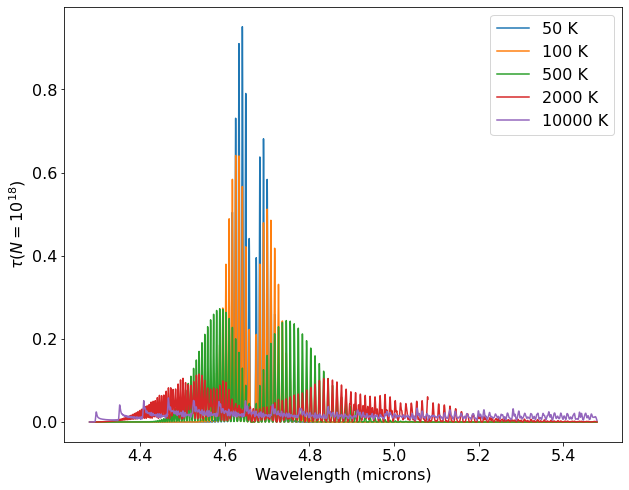

In [37]:
# I think this is code copied over from my old scripts intended to find the location of the CO bandhead?
temperatures = np.linspace(2000,8000,50)
xarr1 = np.linspace(4.28, 4.68,5000)
peak_lambda_one = [ xarr1[pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr1*1e-4,1e18,T,width=20, progressbar=lambda x:x).argmax()] for T in temperatures ] 
xarr2 = np.linspace(4.68, 5.08,5000)
peak_lambda_two = [ xarr2[pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr2*1e-4,1e18,T,width=20, progressbar=lambda x:x).argmax()] for T in temperatures ] 
xarr3 = np.linspace(5.08, 5.48,5000)
peak_lambda_three = [ xarr3[pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr3*1e-4,1e18,T,width=20, progressbar=lambda x:x).argmax()] for T in temperatures ] 

# pylab.figure(17)
# pylab.clf()
# pylab.plot(temperatures,peak_lambda_one)
# pylab.plot(temperatures,peak_lambda_two)
# pylab.plot(temperatures,peak_lambda_three)

pylab.figure(16)
pylab.clf()
for T in [50, 100, 500, 2000, 10000]:
    L, = pylab.plot(xarr1,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr1*1e-4,1e18,T,width=100, progressbar=lambda x:x), label="{0} K".format(T))
    L, = pylab.plot(xarr2,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr2*1e-4,1e18,T,width=100, progressbar=lambda x:x), color=L.get_color())
    L, = pylab.plot(xarr3,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr3*1e-4,1e18,T,width=100, progressbar=lambda x:x), color=L.get_color())
pylab.legend(loc='best')
pylab.xlabel("Wavelength (microns)")
pylab.ylabel("$\\tau(N=10^{18})$")


Text(0, 0.5, '$S_\\nu(N=10^{17})$ [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]')

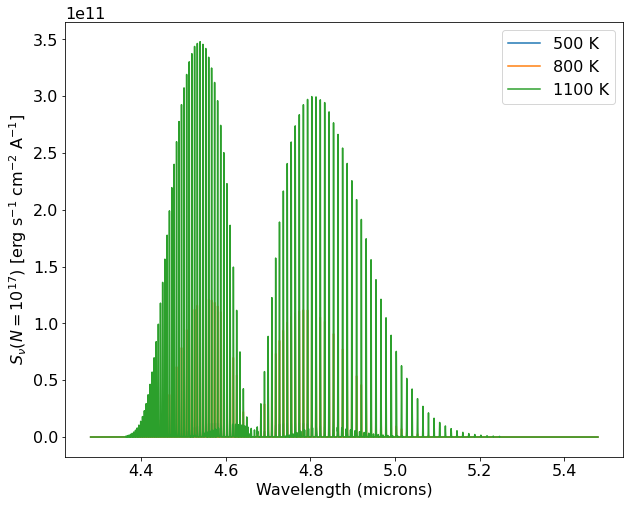

In [38]:
pylab.figure(6)
pylab.clf()
for T in [500, 800, 1100]:
    L, = pylab.plot(xarr1,
                    pyspeckitmodels.co_vibration.modelemissionspectrum(xarr1*1e-4,
                                                                       column=1e17, tex=T,
                                                                       width=20, unit='cm'),
                    label="{0} K".format(T))
    L, = pylab.plot(xarr2,
                    pyspeckitmodels.co_vibration.modelemissionspectrum(xarr2*1e-4,
                                                                       column=1e17, tex=T,
                                                                       width=20, unit='cm'),
                    color=L.get_color())
    L, = pylab.plot(xarr3,
                    pyspeckitmodels.co_vibration.modelemissionspectrum(xarr3*1e-4,
                                                                       column=1e17, tex=T,
                                                                       width=20, unit='cm'),
                    color=L.get_color())
pylab.legend(loc='best')
pylab.xlabel("Wavelength (microns)")
pylab.ylabel("$S_\\nu(N=10^{17})$ [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]")



print("First  bandhead: %f" % np.median(peak_lambda_one))
print("Second bandhead: %f" % np.median(peak_lambda_two))
print("Third  bandhead: %f" % np.median(peak_lambda_three))

temperatures = np.linspace(2000,8000,50)
peak_lambda_13co_one = [ xarr1[pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr1*1e-4,1e18,T,width=20,isotopomer=36).argmax()] for T in temperatures ] 
peak_lambda_13co_two = [ xarr2[pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr2*1e-4,1e18,T,width=20,isotopomer=36).argmax()] for T in temperatures ] 
peak_lambda_13co_three = [ xarr3[pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr3*1e-4,1e18,T,width=20,isotopomer=36).argmax()] for T in temperatures ] 

pylab.figure(19)
pylab.clf()
pylab.plot(temperatures,peak_lambda_13co_one)
pylab.plot(temperatures,peak_lambda_13co_two)
pylab.plot(temperatures,peak_lambda_13co_three)

pylab.figure(18)
pylab.clf()
for T in np.linspace(2000,8000,7):
    pylab.plot(xarr1,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr1*1e-4,1e18,T,width=20,isotopomer=36))
    pylab.plot(xarr2,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr2*1e-4,1e18,T,width=20,isotopomer=36))
    pylab.plot(xarr3,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr3*1e-4,1e18,T,width=20,isotopomer=36))

print("13CO First  bandhead: %f" % np.median(peak_lambda_13co_one))
print("13CO Second bandhead: %f" % np.median(peak_lambda_13co_two))
print("13CO Third  bandhead: %f" % np.median(peak_lambda_13co_three))

pylab.figure(20)
pylab.clf()
for T in np.linspace(20,5000,7):
    l, = pylab.plot(xarr1,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr1*1e-4,1e18,T,width=20,isotopomer=28),label='T=%i' % T)
    l, = pylab.plot(xarr2,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr2*1e-4,1e18,T,width=20,isotopomer=28), color=l.get_color())
    l, = pylab.plot(xarr3,pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr3*1e-4,1e18,T,width=20,isotopomer=28), color=l.get_color())
pylab.legend()

  0%|          | 0/719 [00:00<?, ?it/s]

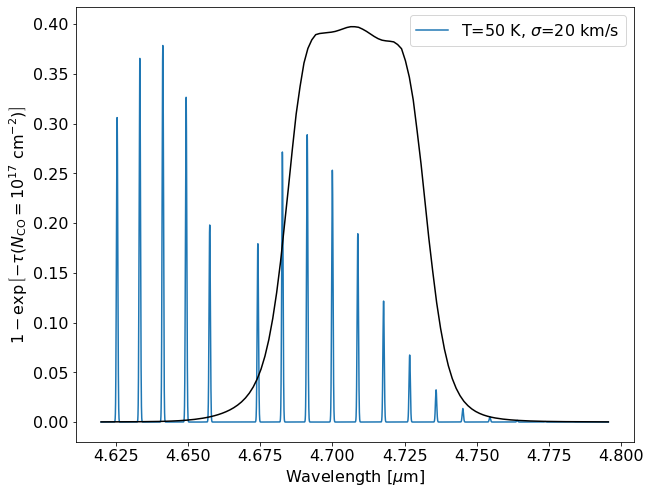

In [39]:
xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))

for T in [50, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e17, T, width=20)
    L, = pl.plot(xarr,
                 (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_470['Transmission']/wavelength_table_470['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{17}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F470N_absorptionspectrum_example_1e17_exptau.pdf', bbox_inches='tight');

  0%|          | 0/815 [00:00<?, ?it/s]

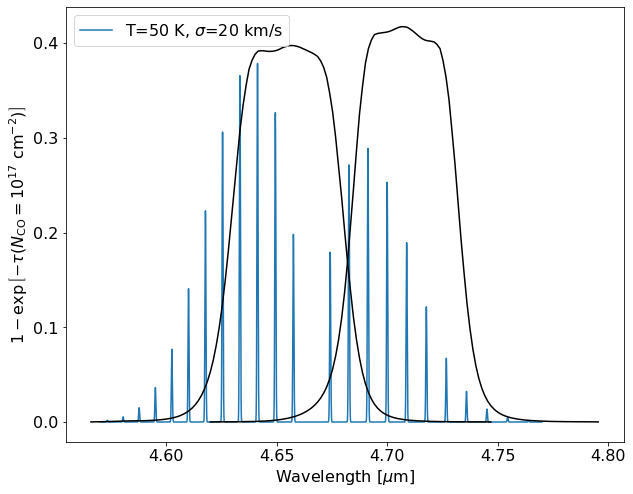

In [40]:
xarr = np.linspace(4.57, 4.77, int(2e4))*u.um

for T in [50, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e17, T, width=20)
    L, = pl.plot(xarr,
                 (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')

xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_470['Transmission']/wavelength_table_470['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{17}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_F470N_absorptionspectrum_example_1e17_exptau.pdf', bbox_inches='tight');

  0%|          | 0/815 [00:00<?, ?it/s]

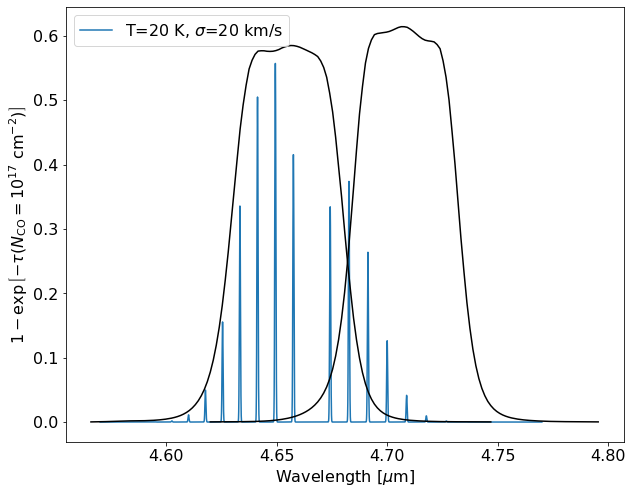

In [41]:
xarr = np.linspace(4.57, 4.77, int(2e4))*u.um

for T in [20, ]:
    tau = pyspeckitmodels.co.exomol_co_vibration.tau_of_N(xarr.to(u.cm).value, 1e17, T, width=20)
    L, = pl.plot(xarr,
                 (1-np.exp(-tau)), label="T={0} K, $\sigma$=20 km/s".format(T))
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max() * pl.ylim()[1],
        color='k')

xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_470['Transmission']/wavelength_table_470['Transmission'].max() * pl.ylim()[1],
        color='k')
pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("$1-\\exp\\left[-\\tau(N_\\mathrm{CO}=10^{17}~\mathrm{cm^{-2}})\\right]$")
pl.savefig(f'{basepath}/paper_figures/CO_F466N_F470N_absorptionspectrum_example_20K_1e17_exptau.pdf', bbox_inches='tight');

# Pontoppidan ice models

In [42]:
# apolar in CO2, apolar pure CO, polar methanol ice
co_ice_wls_icm = ([2143.7, 2139.9, 2136.5] * u.cm**-1)
co_ice_wls = co_ice_wls_icm.to(u.um, u.spectral())
co_ice_widths = (([3.0, 3.5, 10.6] * u.cm**-1)/co_ice_wls_icm * co_ice_wls).to(u.um, u.spectral())
co_ice_bandstrength = 1.1e-17 * u.cm # cm per molecule; Jian+1975 via Boogert+2022
co_ice_wls, co_ice_widths

(<Quantity [4.66483183, 4.67311557, 4.68055231] um>,
 <Quantity [0.0065282 , 0.0076433 , 0.02322202] um>)

## Boogert OCN OCS

In [43]:
ocn_center = 4.62*u.um
ocn_width = 100*u.cm**-1 / (ocn_center.to(u.cm**-1, u.spectral())) * ocn_center
ocs_center = 4.90*u.um
ocn_bandstrength = 1.3e-16*u.cm # per molecule; via Boogert+2022 from van Broekhuizen+2004
ocs_bandstrength = 1.5e-16*u.cm # per molecule; via Boogert+2022 from Palumbo+1997

## Boogert 2015 H2O

In [44]:
water_ice_centers_icm = [1666, 3333]*u.cm**-1
water_ice_widths_icm = [160, 390]*u.cm**-1
water_ice_centers = water_ice_centers_icm.to(u.um, u.spectral())
water_ice_widths = (water_ice_widths_icm / water_ice_centers_icm) * water_ice_centers
water_ice_bandstrengths = [1.2e-17, 2e-16]*u.cm
# first is Gerakines+1995 via Boogert+2007
# second Hagen+1981 vis Boogert+2022 - but this is for the 3um band, not the 6um?
nh4_ice_centers = []
nh4_ice_widths = []
nh4_ice_bandstrengths = []

In [123]:
(3.47*u.um).to(u.cm**-1, u.spectral())

<Quantity 2881.8443804 1 / cm>

In [126]:
# Hudgins 1993, with centers & widths from Boogert 2015
# these don't always agree well
# some also come from Allamandola 1992 (2832 from their 2825 in tbl 2, 2597 from footnote of tbl 3)
methanol_ice_centers_icm = [2881.8, 2832, 2597, 2538, 1459, 1128, 1026]*u.cm**-1
methanol_ice_widths_icm = [80, 30, 40, 40, 85, 15, 30]*u.cm**-1
methanol_ice_centers = methanol_ice_centers_icm.to(u.um, u.spectral())
methanol_ice_widths = (methanol_ice_widths_icm / methanol_ice_centers_icm) * methanol_ice_centers
methanol_ice_bandstrengths = [5.6e-18, 4e-18, 2.6e-18, 2.8e-18, 1.2e-17, 1.8e-18, 1.8e-17]*u.cm
print(len(methanol_ice_centers_icm), len(methanol_ice_widths_icm), len(methanol_ice_bandstrengths))
methanol_ice_centers_icm.to(u.um, u.spectral())

7 7 7


<Quantity [3.47005344, 3.53107345, 3.85059684, 3.94011032, 6.8540096 ,
           8.86524823, 9.74658869] um>

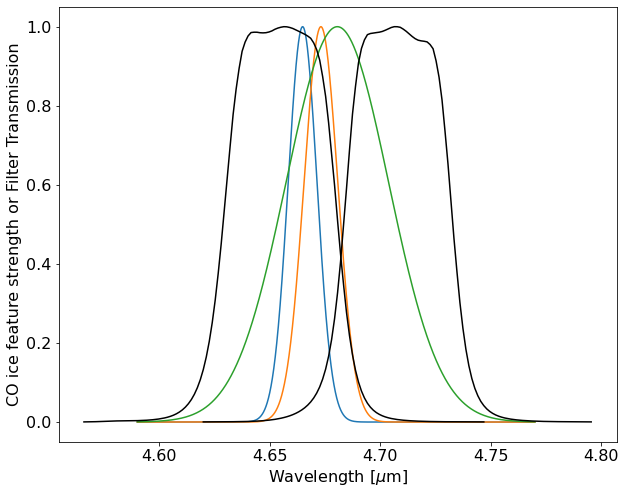

In [45]:
xarr = np.linspace(4.59, 4.77, int(2e4))*u.um

for cen, wid in zip(co_ice_wls, co_ice_widths):
    pl.plot(xarr, np.exp(-(xarr-cen)**2/(2*wid**2)))

xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_470['Transmission']/wavelength_table_470['Transmission'].max(),
        color='k')
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max(),
        color='k')

#pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("CO ice feature strength or Filter Transmission")
pl.savefig(f'{basepath}/paper_figures/CO_Ice_on_466and470.pdf', bbox_inches='tight');

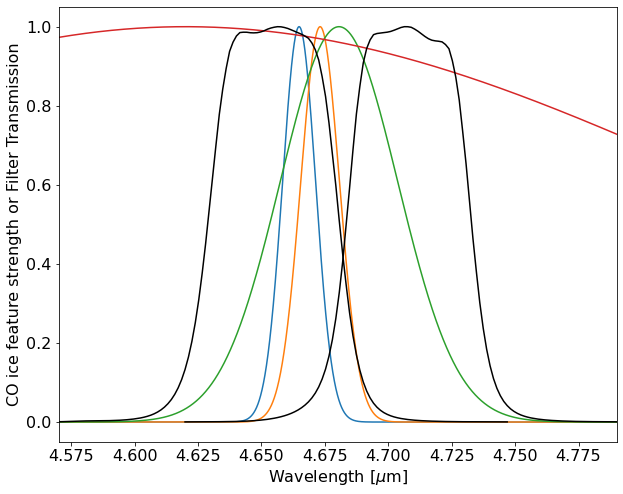

In [107]:
fig = pl.figure(figsize=(10, 8))

xarr = np.linspace(4.55, 4.80, int(2e4))*u.um

for cen, wid in zip(co_ice_wls, co_ice_widths):
    pl.plot(xarr, np.exp(-(xarr-cen)**2/(2*wid**2)))

pl.plot(xarr, np.exp(-(xarr-ocn_center)**2 / (2*ocn_width**2)))
        
xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_470['Transmission']/wavelength_table_470['Transmission'].max(),
        color='k')
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max(),
        color='k')
pl.xlim(4.57, 4.79)
#pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("CO ice feature strength or Filter Transmission")
pl.savefig(f'{basepath}/paper_figures/CO_and_XCN_Ice_on_466and470.pdf', bbox_inches='tight');

# Column - tau - bandstrength relation

Eqn 1 of Boogert:

$$ N = \frac{1}{A} \int \tau_{\nu} d \nu $$

where $d\nu$ is in cm$^{-1}$

So, $\tau_\nu = N A / d\nu$

For a Gaussian profile, $\tau_\nu = \frac{N A}{\sqrt{2 \pi} \sigma}$

In [47]:
np.diff(xarr.to(u.cm**-1, u.spectral()))

<Quantity [-0.64739555, -0.64701293, -0.64663066, -0.65103433, -0.6458643 ,
           -0.64548305, -0.64510213, -0.64472155, -0.6443413 , -0.6439614 ,
           -0.64358182, -0.64796564, -0.64282088, -0.64244232, -0.64206408,
           -0.64168619, -0.64130863, -0.6409314 , -0.6405545 , -0.64491859,
           -0.63979892, -0.63942302, -0.63904745, -0.63867221, -0.63829731,
           -0.63792273, -0.63754848, -0.64189298, -0.63679821, -0.63642495,
           -0.63605203, -0.63567942, -0.63530715, -0.6349352 , -0.63456358,
           -0.63888862, -0.63381857, -0.63344793, -0.63307761, -0.63270762,
           -0.63233795, -0.63196861, -0.63159959, -0.6359053 , -0.63085979,
           -0.63049174, -0.63012401, -0.62975661, -0.62938952, -0.62902276,
           -0.62865632, -0.63294283, -0.62792168, -0.6275562 , -0.62719104,
           -0.62682619, -0.62646167, -0.62609746, -0.62573357, -0.62537   ,
           -0.62963507, -0.62464111, -0.62427849, -0.62391619, -0.6235542 ,
           -

In [48]:
wid

<Quantity 0.02322202 um>

3.0 1 / cm
3.5 1 / cm
10.600000000000001 1 / cm


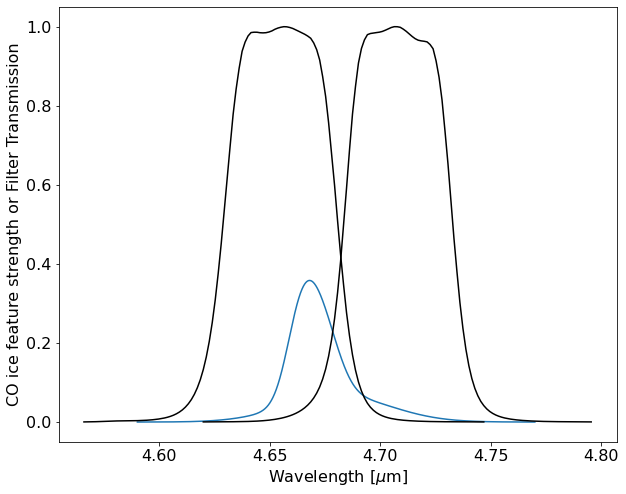

In [49]:
xarr = np.linspace(4.59, 4.77, int(2e4))*u.um

co_ice_column = 5e17*u.cm**-2
tau = np.zeros(xarr.size)
chwidth_icm = np.abs(np.diff(xarr.to(u.cm**-1, u.spectral())).mean()) # not correct! formally should be in freq units
for cen, wid in zip(co_ice_wls, co_ice_widths):
    wid_icm = (wid / cen) * cen.to(u.cm**-1, u.spectral())
    print(wid_icm)
    tau += (co_ice_column / len(co_ice_wls) * co_ice_bandstrength / ((2*np.pi)**0.5 * wid_icm) * np.exp(-(xarr-cen)**2/(2*wid**2))).decompose().value
#pl.plot(xarr, np.exp(-(xarr-cen)**2/(2*wid**2)))
#pl.plot(xarr, np.exp(-(xarr-ocn_center)**2 / (2*ocn_width**2)))
pl.plot(xarr, 1-np.exp(-tau))
        
xarr = wavelength_table_470['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_470['Transmission']/wavelength_table_470['Transmission'].max(),
        color='k')
xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
pl.plot(xarr, wavelength_table_466['Transmission']/wavelength_table_466['Transmission'].max(),
        color='k')

#pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("CO ice feature strength or Filter Transmission")
pl.savefig(f'{basepath}/paper_figures/CO_and_XCN_Ice_absorptionmodel_on_466and470.pdf', bbox_inches='tight');

In [50]:
co_ice_column, co_ice_bandstrength, chwidth_icm

(<Quantity 5.e+17 1 / cm2>,
 <Quantity 1.1e-17 cm>,
 <Quantity 0.00411086 1 / cm>)

In [51]:
co_ice_column * co_ice_bandstrength / chwidth_icm

<Quantity 1337.91810075>

# Compute fractional absorption in each of the ice bands

In [196]:
co_ice_widths

<Quantity [0.0065282 , 0.0076433 , 0.02322202] um>

$$ N A = \int \tau_\nu d\nu$$

In [247]:
def fractional_absorption_ice(ice_column, center, width, ice_bandstrength, return_tau=False):
    xarr = wavelength_table_466['Wavelength'].quantity.to(u.um)
    xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))
    xarr_nu = xarr.to(u.cm**-1, u.spectral())
    dx = (xarr[1]-xarr[0])
    dx_icm = np.abs(xarr_nu[1] - xarr_nu[0])
    trans = np.interp(xarr, wavelength_table_466['Wavelength'], wavelength_table_466['Transmission'])
    transmission_sum = (trans).sum()

    center_nu = center.to(u.cm**-1, u.spectral())
    
    tau = np.zeros(xarr.size)
    wid_icm = (width / center) * center_nu
    line_profile = 1/((2*np.pi)**0.5 * wid_icm) * np.exp(-(xarr_nu-center_nu)**2/(2*wid_icm**2))
    #print(line_profile.unit, (line_profile * dx_icm).decompose().sum())

    # \int line_profile * dnu = 1
    
    tau = tau + (ice_column * ice_bandstrength * line_profile).decompose()
    assert tau.unit is u.dimensionless_unscaled
    if return_tau:
        print(ice_column, ice_bandstrength, "tau:", tau.sum(), "tau dnu sum:", (tau*dx_icm).sum(), "line prof:", (line_profile * dx_icm).sum(), "width:", width, "width icm:",wid_icm, dx_icm)
        return tau
    absorbed_fraction = (((1-np.exp(-tau)) * trans).sum() / transmission_sum).value
    return absorbed_fraction

In [248]:
# sanity check: integral(tau) should be 1 because N A = 1
fractional_absorption_ice(1.1e17*u.cm**-2, co_ice_wls[0], co_ice_widths[0], co_ice_bandstrength, return_tau=True).sum()

1.1e+17 1 / cm2 1.1e-17 cm tau: 145.40186359997244 tau dnu sum: 1.2630557307674255 1 / cm line prof: 1.0438477113780376 width: 0.006528196808526045 um width icm: 3.0 1 / cm 0.008686654348821321 1 / cm


<Quantity 145.4018636>

In [249]:
column = np.logspace(16, 21, 100)*u.cm**-2
grid_co_in_co2_ice = [fractional_absorption_ice(col, co_ice_wls[0], co_ice_widths[0], co_ice_bandstrength) for col in column]
grid_co_pure_ice = [fractional_absorption_ice(col, co_ice_wls[1], co_ice_widths[1], co_ice_bandstrength) for col in column]
grid_co_methanol_ice = [fractional_absorption_ice(col, co_ice_wls[2], co_ice_widths[2], co_ice_bandstrength) for col in column]
grid_ocn = [fractional_absorption_ice(col, ocn_center, ocn_width, ocn_bandstrength) for col in column]

divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10


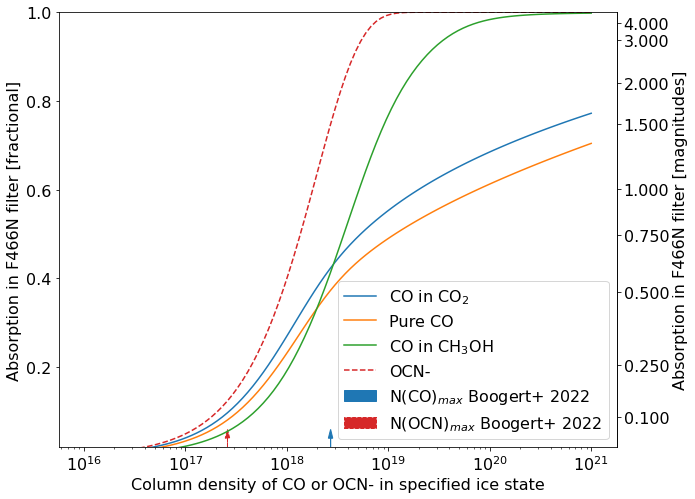

In [250]:
fig = pl.figure(figsize=(10, 8))
ax = fig.gca()

LCO, = pl.semilogx(column, grid_co_in_co2_ice, label='CO in CO$_2$')
pl.semilogx(column, grid_co_pure_ice, label='Pure CO')
pl.semilogx(column, grid_co_methanol_ice, label='CO in CH$_3$OH')
LOCN, = pl.semilogx(column, grid_ocn, linestyle='--', label='OCN-')

def col2mag(x):
    ret = -2.5*np.log10(1-np.array(x))
    ret[~np.isfinite(ret)] = 999
    return ret
def mag2col(x):
    return 1-10**(-x/2.5)

secax = ax.secondary_yaxis('right', functions=(col2mag, mag2col, ))
secax.set_ylabel("Absorption in F466N filter [magnitudes]")
secax.set_ticks([0.001, 0.01, 0.1, 0.25, 0.50, 0.75, 1, 1.5, 2, 3, 4])

pl.ylim(0.02, 1)# NOTE: conversion breaks if this is not 1!!
pl.legend(loc='best')
pl.xlabel("Column density of CO or OCN- in specified ice state")
pl.ylabel("Absorption in F466N filter [fractional]")

fig.savefig(f'{basepath}/paper_figures/IceAbsorptionvsColumn_linear.pdf', bbox_inches='tight');

pl.arrow(2.7e18, 0, 0, 0.04, color=LCO.get_color(), label='N(CO)$_{max}$ Boogert+ 2022', head_width=2.7e17, head_length=0.02)
pl.arrow(2.6e17, 0, 0, 0.04, color=LOCN.get_color(), linestyle='--', label='N(OCN)$_{max}$ Boogert+ 2022', head_width=2.6e16, head_length=0.02)
pl.legend(loc='best')

fig.savefig(f'{basepath}/paper_figures/IceAbsorptionvsColumn_linear_withBoogertMaxima.pdf', bbox_inches='tight');

divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10


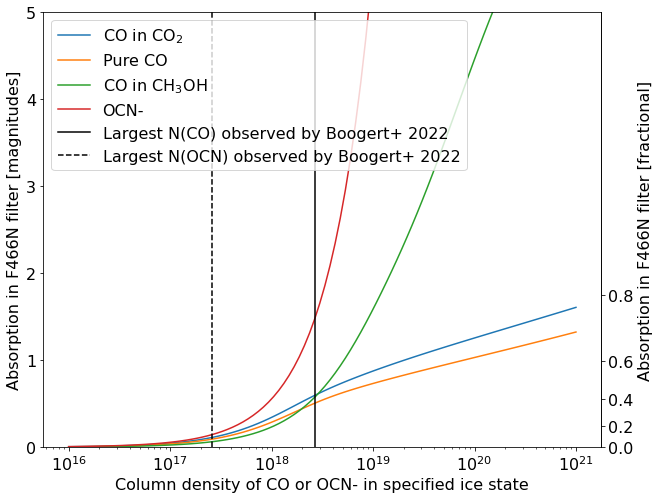

In [251]:
pl.semilogx(column, -2.5*np.log10(1-np.array(grid_co_in_co2_ice)), label='CO in CO$_2$')
pl.semilogx(column, -2.5*np.log10(1-np.array(grid_co_pure_ice)), label='Pure CO')
pl.semilogx(column, -2.5*np.log10(1-np.array(grid_co_methanol_ice)), label='CO in CH$_3$OH')
pl.semilogx(column, -2.5*np.log10(1-np.array(grid_ocn)), label='OCN-')
#pl.semilogx(column, grid_co_in_co2_ice, label='CO in CO$_2$')
#pl.semilogx(column, grid_co_pure_ice, label='Pure CO')
#pl.semilogx(column, grid_co_methanol_ice, label='CO in CH$_3$OH')
#pl.semilogx(column, grid_ocn, label='OCN-')


def col2mag(x):
    return -2.5*np.log10(1-np.array(x))
def mag2col(x):
    return 1-10**(-x/2.5)

ax = pl.gca()
secax = ax.secondary_yaxis('right', functions=(mag2col, col2mag, ))
secax.set_ylabel("Absorption in F466N filter [fractional]")

pl.legend(loc='best')
pl.xlabel("Column density of CO or OCN- in specified ice state")
pl.ylabel("Absorption in F466N filter [magnitudes]")
pl.ylim([0,5]);
pl.savefig(f'{basepath}/paper_figures/IceAbsorptionvsColumn_magnitudes.pdf', bbox_inches='tight');

pl.axvline(2.7e18, color='k', label='Largest N(CO) observed by Boogert+ 2022')
pl.axvline(2.6e17, color='k', linestyle='--', label='Largest N(OCN) observed by Boogert+ 2022')
pl.legend(loc='best')

pl.savefig(f'{basepath}/paper_figures/IceAbsorptionvsColumn_magnitudes_withBoogertMaxima.pdf', bbox_inches='tight');

# Spitzer absorptions

In [56]:
instrument = 'IRAC'
telescope = 'Spitzer'
wavelength_tables_spitzer = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                             for filt in ['I1', 'I2', 'I3', 'I4']}

In [57]:
wavelength_tables = {'f470n': wavelength_table_470,
                     'f466n': wavelength_table_466,
                    }
wavelength_tables.update(wavelength_tables_spitzer)

Text(0, 0.5, 'Ice feature strength or Filter Transmission')

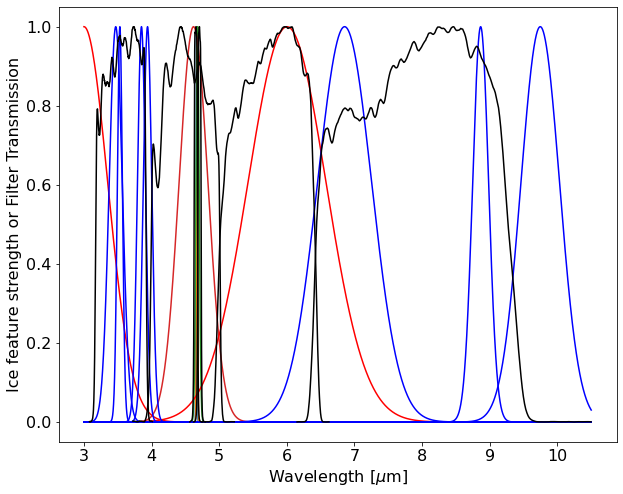

In [132]:
xarr = np.linspace(3.0, 10.5, int(5e4))*u.um

for cen, wid in zip(co_ice_wls, co_ice_widths):
    pl.plot(xarr, np.exp(-(xarr-cen)**2/(2*wid**2)))

pl.plot(xarr, np.exp(-(xarr-ocn_center)**2 / (2*ocn_width**2)))

for cen, wid in zip(water_ice_centers, water_ice_widths):
    pl.plot(xarr, np.exp(-(xarr-cen)**2/(2*wid**2)), color='r')

for cen, wid in zip(methanol_ice_centers, methanol_ice_widths):
    pl.plot(xarr, np.exp(-(xarr-cen)**2/(2*wid**2)), color='b')
    
for filt, tbl in wavelength_tables.items():
    xarr = tbl['Wavelength'].quantity.to(u.um)
    pl.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(),
            color='k')

#pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("Ice feature strength or Filter Transmission")
#pl.savefig(f'{basepath}/paper_figures/Ices_on_SpitzerandWebb.pdf', bbox_inches='tight');

In [59]:
def fractional_absorption_ice_filter(ice_column, center, width, ice_bandstrength, tbl):
    xarr = tbl['Wavelength'].quantity.to(u.um)
    xarr = np.linspace(xarr.min(), xarr.max(), int(1e4))
    trans = np.interp(xarr, tbl['Wavelength'], tbl['Transmission'])
    transmission_sum = (trans).sum()

    tau = np.zeros(xarr.size)
    wid_icm = (width / center) * center.to(u.cm**-1, u.spectral())
    tau += (ice_column * ice_bandstrength / ((2*np.pi)**0.5 * wid_icm) * np.exp(-(xarr-center)**2/(2*width**2))).decompose().value
    absorbed_fraction = ((1-np.exp(-tau)) * trans).sum() / transmission_sum
    return absorbed_fraction

In [60]:
water_ice_centers

<Quantity [6.00240096, 3.00030003] um>

In [61]:
column = np.logspace(17, 21, 100)*u.cm**-2
grid_water_I1 = [fractional_absorption_ice_filter(col, water_ice_centers[1], water_ice_widths[1],
                                                  water_ice_bandstrengths[1], wavelength_tables['I1'])
                 for col in column]
grid_water_I3 = [fractional_absorption_ice_filter(col, water_ice_centers[0], water_ice_widths[0],
                                                  water_ice_bandstrengths[0], wavelength_tables['I3'])
                 for col in column]
grid_water_I4 = [fractional_absorption_ice_filter(col, water_ice_centers[0], water_ice_widths[0],
                                                  water_ice_bandstrengths[0], wavelength_tables['I4'])
                 for col in column]
grid_CO_I2 = [fractional_absorption_ice_filter(col, co_ice_wls[2], co_ice_widths[2],
                                                  co_ice_bandstrength, wavelength_tables['I2'])
                 for col in column]

divide by zero encountered in log10
divide by zero encountered in log10


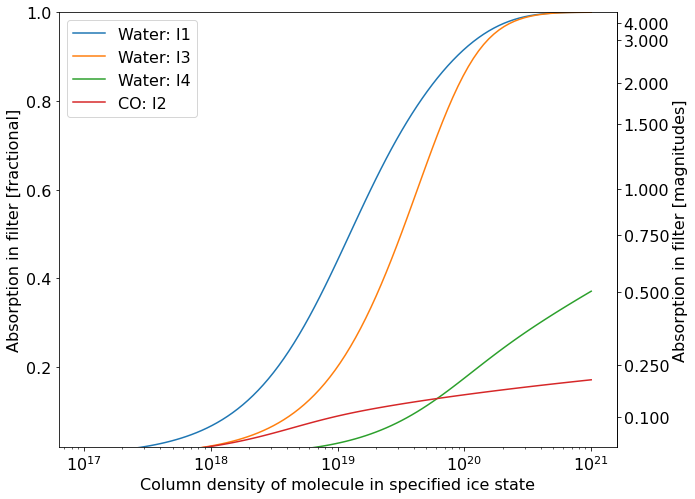

In [62]:
pl.semilogx(column, grid_water_I1, label='Water: I1')
pl.semilogx(column, grid_water_I3, label='Water: I3')
pl.semilogx(column, grid_water_I4, label='Water: I4')
pl.semilogx(column, grid_CO_I2, label='CO: I2')

def col2mag(x):
    ret = -2.5*np.log10(1-np.array(x))
    ret[~np.isfinite(ret)] = 999
    return ret
def mag2col(x):
    return 1-10**(-x/2.5)

ax = pl.gca()
secax = ax.secondary_yaxis('right', functions=(col2mag, mag2col, ))
secax.set_ylabel("Absorption in filter [magnitudes]")
secax.set_ticks([0.001, 0.01, 0.1, 0.25, 0.50, 0.75, 1, 1.5, 2, 3, 4])

pl.ylim(0.02, 1)# NOTE: conversion breaks if this is not 1!!
pl.legend(loc='best')
pl.xlabel("Column density of molecule in specified ice state")
pl.ylabel("Absorption in filter [fractional]")

pl.savefig(f'{basepath}/paper_figures/WaterIce_SpitzerFilters.pdf', bbox_inches='tight');

In [137]:
methanol_ice_centers.to(u.um)

<Quantity [3.47005344, 3.53107345, 3.85059684, 3.94011032, 6.8540096 ,
           8.86524823, 9.74658869] um>

In [140]:
column = np.logspace(17, 21, 100)*u.cm**-2
grid_methanol_I1a = [fractional_absorption_ice_filter(col, methanol_ice_centers[0], methanol_ice_widths[0],
                                                  methanol_ice_bandstrengths[0], wavelength_tables['I1'])
                 for col in column]
grid_methanol_I1b = [fractional_absorption_ice_filter(col, methanol_ice_centers[1], methanol_ice_widths[1],
                                                  methanol_ice_bandstrengths[1], wavelength_tables['I1'])
                 for col in column]
grid_methanol_I1c = [fractional_absorption_ice_filter(col, methanol_ice_centers[2], methanol_ice_widths[2],
                                                  methanol_ice_bandstrengths[2], wavelength_tables['I1'])
                 for col in column]


grid_methanol_I3 = [fractional_absorption_ice_filter(col, methanol_ice_centers[4], methanol_ice_widths[4],
                                                  methanol_ice_bandstrengths[4], wavelength_tables['I3'])
                 for col in column]
grid_methanol_I4a = [fractional_absorption_ice_filter(col, methanol_ice_centers[5], methanol_ice_widths[5],
                                                  methanol_ice_bandstrengths[5], wavelength_tables['I4'])
                 for col in column]
grid_methanol_I4b = [fractional_absorption_ice_filter(col, methanol_ice_centers[6], methanol_ice_widths[6],
                                                  methanol_ice_bandstrengths[6], wavelength_tables['I4'])
                 for col in column]

divide by zero encountered in log10
divide by zero encountered in log10


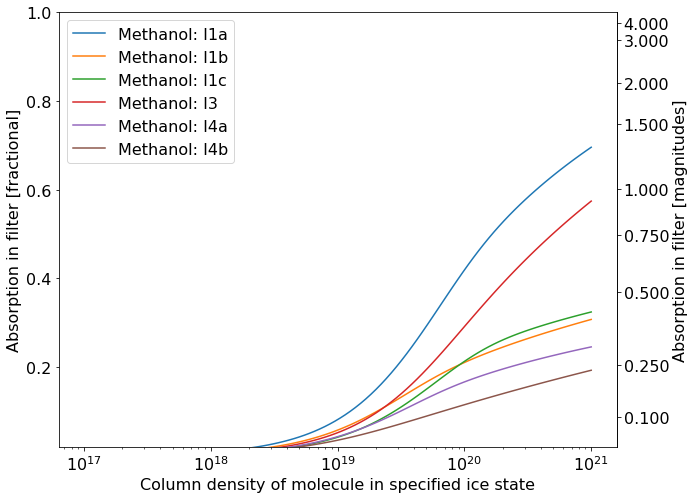

In [141]:
pl.semilogx(column, grid_methanol_I1a, label='Methanol: I1a')
pl.semilogx(column, grid_methanol_I1b, label='Methanol: I1b')
pl.semilogx(column, grid_methanol_I1c, label='Methanol: I1c')
pl.semilogx(column, grid_methanol_I3, label='Methanol: I3')
pl.semilogx(column, grid_methanol_I4a, label='Methanol: I4a')
pl.semilogx(column, grid_methanol_I4b, label='Methanol: I4b')

def col2mag(x):
    ret = -2.5*np.log10(1-np.array(x))
    ret[~np.isfinite(ret)] = 999
    return ret
def mag2col(x):
    return 1-10**(-x/2.5)

ax = pl.gca()
secax = ax.secondary_yaxis('right', functions=(col2mag, mag2col, ))
secax.set_ylabel("Absorption in filter [magnitudes]")
secax.set_ticks([0.001, 0.01, 0.1, 0.25, 0.50, 0.75, 1, 1.5, 2, 3, 4])

pl.ylim(0.02, 1)# NOTE: conversion breaks if this is not 1!!
pl.legend(loc='best')
pl.xlabel("Column density of molecule in specified ice state")
pl.ylabel("Absorption in filter [fractional]")

pl.savefig(f'{basepath}/paper_figures/MethanolIce_SpitzerFilters.pdf', bbox_inches='tight');

# Gordon+ 2021 give a model for the 9.7 um feature as a Drude profile

$$ D_m(\lambda) = \frac{(\gamma/\lambda_0)^2}{(\lambda/\lambda_0 - \lambda_0/\lambda)^2 + (\gamma/\lambda)^2}$$

$$\gamma = \frac{\gamma_0}{1+\exp\left[a(\lambda-\lambda_0)\right]}$$

In [63]:
def silicate_drude(lam, S1=1, a=-0.5, lambda0=9.7*u.um, gamma0=2*u.um):
    dlambda = (lam-lambda0).decompose()
    gamma = gamma0 / (1+np.exp(a*(lam-lambda0).to(u.um).value))
    dm = (gamma/lambda0)**2 / ((lam/lambda0 - lambda0/lam)**2 + (gamma/lam)**2)
    return dm * S1

Text(0, 0.5, 'Silicate feature strength or Filter Transmission')

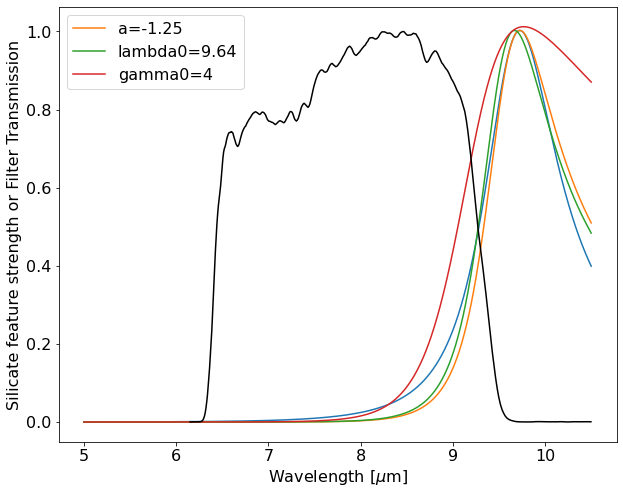

In [64]:
xarr = np.linspace(5.0, 10.5, int(5e4))*u.um

pl.plot(xarr, silicate_drude(xarr))
pl.plot(xarr, silicate_drude(xarr, a=-1.25), label='a=-1.25')
pl.plot(xarr, silicate_drude(xarr, a=-1.25, lambda0=9.64*u.um), label='lambda0=9.64')
pl.plot(xarr, silicate_drude(xarr, a=-1.25, lambda0=9.64*u.um, gamma0=4*u.um), label='gamma0=4')


tbl = wavelength_tables['I4']
xarr = tbl['Wavelength'].quantity.to(u.um)
pl.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(),
        color='k')

pl.legend(loc='best')
pl.xlabel(f"Wavelength [$\mu$m]")
pl.ylabel("Silicate feature strength or Filter Transmission")
#pl.savefig(f'{basepath}/paper_figures/Ices_on_SpitzerandWebb.pdf', bbox_inches='tight');

# what if it's gas-phase SiO?

fig 1 of https://ui.adsabs.harvard.edu/abs/2011A%26A...526A.152V/abstract caption says the short-wavelength component of the silicate feature (which overlaps heavily with the IRAC4 filter) is from gas-phase SiO

In short, it can't be gas-phase SiO: the exomol cross-section page (and my own calculations, though they came up waaaaay different) gives cross sections peaking around $3\times10^{-17}$ per molecule, so we'd need $N(SiO) \sim 10^{17}$ to get significant absorption, which implies abundances $X_{SiO} > 10^{-5}$, which is implausible.